## Basic functions

In [1]:
import tensorflow as tf  # tf 2.x
import tensornetwork as tn
tn.set_default_backend("tensorflow")
from tensornetwork import ncon
import matplotlib.pyplot as plt
import math
import cmath
import numpy as np

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

In [2]:
import general_utils as util
import channel_utils as c_util
import json

In [3]:
from QCCalc import QCEvaluator
'''
this class contains so-called evaluators of type QCEvaluator.
Each QCEvaluator is initialized with number of qubits and set of gates it works with (or gate channels)
They contain different tensor network templates, accessible by name.
A tensor network template is the array of arrays which gets passed into NCON, defining a TN structure.
An evaluator can evaluate any amplitude of probability obtaining a given bitstring as the output of the circuit.
Also having access to the same probability distribution, evaluator can generate samples for any circuit
'''

'\nthis class contains so-called evaluators of type QCEvaluator.\nEach QCEvaluator is initialized with number of qubits and set of gates it works with (or gate channels)\nThey contain different tensor network templates, accessible by name.\nA tensor network template is the array of arrays which gets passed into NCON, defining a TN structure.\nAn evaluator can evaluate any amplitude of probability obtaining a given bitstring as the output of the circuit.\nAlso having access to the same probability distribution, evaluator can generate samples for any circuit\n'

In [4]:
def print_loss_dyn(loss_dynamics, num):
    plt.plot(loss_dynamics, label = num)
    plt.yscale('log')
    plt.xlabel('iter')
    plt.ylabel('err')
    plt.legend()
    return

### Gate variables

In [5]:
Hadamard = tf.constant([[1, 1],
                        [1, -1]], dtype=tf.complex64) / math.sqrt(2)

S = util.matr_Rz(math.pi/2)

T = util.matr_Rz(math.pi/4)

E = tf.eye(2, dtype=tf.complex64)

CZ_44 = tf.constant([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, -1]], dtype=tf.complex64)

E_44 = tf.eye(4, dtype=tf.complex64)

CNOT_44 = tf.constant([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, 1],
                    [0, 0, 1, 0]], dtype=tf.complex64) 
RNOT_44 = tf.constant([[1, 0, 0, 0],
                    [0, 0, 0, 1],
                    [0, 0, 1, 0],
                    [0, 1, 0, 0]], dtype=tf.complex64)

#CNOT = util.convert_44_to_2222(CNOT_44)
#CZ = util.convert_44_to_2222(CZ_44)
#RNOT = util.convert_44_to_2222(RNOT_44)
#big_E = util.convert_44_to_2222(E_44)

CNOT = util.swap_legs(tf.reshape(CNOT_44, (2, 2, 2, 2)))
CZ = util.swap_legs(tf.reshape(CZ_44, (2, 2, 2, 2)))
RNOT = util.swap_legs(tf.reshape(RNOT_44, (2, 2, 2, 2)))
big_E = util.swap_legs(tf.reshape(E_44, (2, 2, 2, 2)))

H_channel = c_util.convert_1qmatrix_to_channel(Hadamard)
S_channel = c_util.convert_1qmatrix_to_channel(S)
T_channel = c_util.convert_1qmatrix_to_channel(T)
CZ_channel = c_util.convert_2qmatrix_to_channel(CZ)
CNOT_channel = c_util.convert_2qmatrix_to_channel(CNOT)
big_E_channel = c_util.convert_2qmatrix_to_channel(big_E)
RNOT_channel = c_util.convert_2qmatrix_to_channel(RNOT)

H_choi = c_util.convert_channel_to_params(H_channel)
S_choi = c_util.convert_channel_to_params(S_channel)
T_choi = c_util.convert_channel_to_params(T_channel)
CZ_choi = c_util.convert_channel_to_params(CZ_channel)
CNOT_choi = c_util.convert_channel_to_params(CNOT_channel)
big_E_choi = c_util.convert_channel_to_params(big_E_channel)
RNOT_choi = c_util.convert_channel_to_params(RNOT_channel)

In [6]:
pure_channels_set = {'H':H_channel, 'S':S_channel, 'T':T_channel, 'CZ':CZ_channel}
pure_chois_set = {'H':H_choi, 'S':S_choi, 'T':T_choi, 'CZ':CZ_choi}

#matr_Rz(math.pi/2.8)[tf.newaxis],
#matr_Rz(math.pi/4.1)[tf.newaxis]
'''This is a "pure" set of gates which exist in our mathematical model.
They are considered pure in a sense that they have no noise at all. 
Any circuits the user runs on his quantum computer must contain only gates described here.
However, due to imperfectons his version of the same set can be different.
Futhermore, in the future versions we should note that each qubit can have its own "noised" versions.''' 

'This is a "pure" set of gates which exist in our mathematical model.\nThey are considered pure in a sense that they have no noise at all. \nAny circuits the user runs on his quantum computer must contain only gates described here.\nHowever, due to imperfectons his version of the same set can be different.\nFuthermore, in the future versions we should note that each qubit can have its own "noised" versions.'

### Compatibility with Zhenya & Julio

In [7]:
def save_bitstrings_to_file(QC):
    a_file = open("json/bitstrings.json", "w")
    dict_to_export = {}
    for name in QC.samples_vault:
        dict_to_export[name] = QC.samples_vault[name].numpy().tolist()
    json.dump(dict_to_export, a_file)
    a_file.close()

def import_bitstrings_from_file(QC):
    a_file = open("json/bitstrings.json", "r")
    big_dict = json.load(a_file)
    for name in big_dict:
        QC.samples_vault[name] = tf.convert_to_tensor(big_dict[name], dtype=tf.int32)
    a_file.close()

In [8]:
def save_templates_to_file(QC):
    a_file = open("json/templates.json", "w")
    dict_to_export = {}
    for name in QC.tn_templates:
        dict_to_export[name] = QC.tn_templates[name]
    json.dump(dict_to_export, a_file)
    a_file.close()

def import_templates_from_file(QC):
    a_file = open("json/templates.json", "r")
    big_dict = json.load(a_file)
    #big_dict = convert_templates_to_ncon(big_dict, QC.n)
    for name in big_dict:
        QC.tn_templates[name] = big_dict[name]
    a_file.close()

In [9]:
def extract_info_from_string(string):
    parse = string.split("_")
    if parse[0] == 'E':
        return 4, -1, -1
    elif parse[0] == 'H':
        return 0, int(parse[1]), -1
    elif parse[0] == 'S':
        return 1, int(parse[1]), -1
    elif parse[0] == 'T':
        return 2, int(parse[1]), -1
    elif parse[0] == 'CZ':
        return 3, int(parse[1]), int(parse[2])
    else:
        raise 'WRONG FORMAT OF GATE NAME'
    
def create_tensor_id(gate_type, q1, q2, n):
    if (gate_type >= 5) or (gate_type < 0):
        raise ('WRONG TENSOR ID')
    elif gate_type == 4:
        return int(3 * n + n * (n - 1) / 2)
    elif gate_type == 3:
        if q1 < q2:
            return int(3 * n + (q1 - 1) * (2 * n - q1) / 2 + (q2 - q1 - 1))
        else:
            return int(3 * n + (q2 - 1) * (2 * n - q2) / 2 + (q1 - q2 - 1))
    else:
        return (n * gate_type + q1 - 1)

def convert_templates_to_ncon(tn_templates, n):
    new_templates = {}
    for name in tn_templates:
        tensors, net_struc, con_order, out_order = tn_templates[name]
        new_tensors = []
        for it in range(len(tensors)):
            gate_type, q1, q2 = extract_info_from_string(tensors[it])
            #print(tensors[it], gate_type, q1, q2)
            new_tensor_id = create_tensor_id(gate_type, q1, q2, n)
            new_tensors.append(new_tensor_id)
        new_templates[name] = [new_tensors, net_struc, con_order, out_order]
    return new_templates

## Main Body

In [10]:
def unwrap_dict(target): #maybe needs to be rewritten in case dict mixes its names
    """
    Converts a dict into a long 1D array, dropping the dict names in the process

    Args:
        target: a python dictionary

    Returns:
        1D array of elements written one after another
        The grouping and names of the groups are lost in the process
    """
    output = []
    for name in target:
        for elem in target[name]:
            output.append(elem) #hope it makes a copy
    return output

def get_complex_channel_form(target): 
    """
    Is usually applied to a workspace set of the QuantumCircuits class.
    The problems with it are:
    1) the set is stored in real form with shape (..., 2)
    2) the set has parameter representations A while evaluators work with quantum channels
    
    Since functions qgo.manifolds.real_to_complex() and convert_params_to_channel() cannot be applied to a dict,
    this function breaks the dict into 1D arrays of gates and then converts each array one-by-one
    
    Args:
        target: a python dictionary containing some real-valued parameter representations
        of tensors that are in fact complex; shape is (..., 2)

    Returns:
        The more adequate complex-valued tensors in a dictionary with the same grouping     
    """
    new_set = {}
    for name in target:
        new_set[name] = c_util.convert_params_to_channel(qgo.manifolds.real_to_complex(target[name]))
    return new_set

def simplify_sample(sample):
    """
    WORK IN PROGRESS, maybe it's impossible to implement this function at all
    the idea is to convert an array of 10000 bitstrings to a dict where 
    the NAME will be a bitstring [0/1, 0/1, ..., 0/1], and the ELEM will be number of times
    the bitstring is encountered in the sample
    """
    new_dict = {}
    for bitstring in sample:
        if bitstring not in new_dict:
            new_dict[bitstring] = 1
        else:
            new_dict[bitstring] += 1
    return new_set

In [11]:
class QuantumCircuits:
    """
    This is a class which contains everything we need to run the program.
    
    Attributes:
        n: number of qubits the circuit has. Is quite important, since the amount
        of 'noisy copies' of each single-qubit gate is equal to number of qubits.
    
        ideal_set: is a 'pure' set of gate channels which exist in our mathematical model.
        The gates are considered pure in a sense that they have no noise at all. 
        Any circuits the user runs on their quantum computer must contain only gates described here.
        However, due to imperfectons user's version of the same set can be different.
        Each channel representing a single-qubit gate is a 4x4 complex-valued matrix.
        Each channel representing a two-qubit gate is a 4x4x4x4 complex-valued matrix.
        
        hidden_set: is a set of gate channels the user has in their quantum computer.
        They are the "real" versions of gates, and can be considered as our final goal when optimizing.
        After some iterations of optimizers, we want our "workspace" channels to be like the "real" versions.
        There are n copies of single-qubit gates, and n(n-1)/2 copies of two-qubit gates.
        The representation of gate channels is the same as in 'ideal_set'
    
        workspace_set: is a set of gate channels we actively work with.
        These channels are initialized as an 'ideal_set'. 
        However, iteration-by-iteration they are tuned to be closer and closer to 'real' noised versions.
        IMPORTANT: these matrices are real-valued but contain one extra dimension.
        So we can perceive them as a 4x4x2/4x4x4x4x2 matrices (last dim is for 'Im' part and 'Re' part)
        
        tn_templates: is a dictionary of tensor newtork templates which get passed into NCON function.
        Each template is accessible by its own name. 
        These templates are then passed into evaluators (see later).
        
        samples_vault: is a dictionary of samples which can be generated for each circuit.
        A sample is a 2D array of zeros or ones, containing usually 10000 1D arrays - bitsrings.
        Each sample is accessible by its own name. In theory, the names in 'samples_vault' 
        CAN be different from ones used in 'tn_templates', but it is much better to keep them same.
        
        eval_pure: an evaluator of type QCEvaluator which contains "pure" gates ('ideal_set').
        Not used at the moment.
        
        eval_hidden: an evaluator of type QCEvaluator which contains "real" gates ('hidden_set').
        Used for sample generation.
        
        eval_workspace: an evaluator of type QCEvaluator which contains "workspace" gates ('workspace_set').
        Used for calculating the probability distribution, thus obtaining the cost function for the optimizer.
        
    Functions:
        add_circuit: adds a circuit to tn_templates dictionary.
        As for now, they DO NOT get immediately passed in evaluators!
        
        _simple_template: since 'eval_pure' has only four gates, the tn_template must be simplified 
        before getting passed into evaluator. Remember, set of channels does not have multiple 
        noised versions. 'eval_pure' will not work with the same template!
        
        pass_circuits_to_evals: adds each tn_template in 'tn_templates' to all three evaluators. 
        
        init_hidden_channels: The procedure of applying some kind of a noise to simulate user's noised version of gates [demo]
        
        generate_sample: The procedure of generating N (default=10000) outputs of a circuit defined by 'name'.
        Uses 'eval_hidden', so don't forget to pass the circuit in in 'tn_templates' to it!
        
        generate_all_samples: The procedure of generating N (default=10000) outputs after N runs of all circuits.
        
        _loss_and_grad: ...
        
        train_optimizer: Trains an optimizer passed in the function.
        Also yields a list of 'loss' values per iteration.
    """
    
    def __init__(self, n, pure_chois_set, pure_channels_set):
        self.n = n
        
        self.ideal_set = []
        for name in pure_channels_set:
            self.ideal_set.append(pure_channels_set[name])
        
        self.hidden_set = None
        self.init_hidden_channels(pure_channels_set)
        
        workspace_set = None
        self.init_workspace(pure_chois_set)
        
        self.tn_templates = {} #label -> list(list1, list2, list3, list4)
        
        self.samples_vault = {} #label -> tf.tensor(bs, n)
        
        self.eval_pure = QCEvaluator(self.ideal_set, self.n)
        self.eval_hidden = QCEvaluator(unwrap_dict(self.hidden_set), self.n)
        self.eval_workspace = QCEvaluator(unwrap_dict(get_complex_channel_form(self.workspace_set)), self.n) #WILL NOT WORK
        
    def add_circuit(self, tn_template, name):
        self.tn_templates[name] = tn_template
        #template = [gates_order, ncon]
        return
    
    def _simple_template(self, name): 
        #need to change gates in the TN template 
        #we have n H, n S, n T, n(n-1)/2  CZ
        #need 1 H, 1 S, 1 T, 1 CZ
        #works only for N-S-T-CZ combination
        tensors, net_struc, con_order, out_order = self.tn_templates[name]
        
        new_tensors = tensors.copy()
        for i in range(len(new_tensors)):
            if (new_tensors[i] == 3 * self.n + self.n * (self.n - 1) / 2):
                new_tensors[i] = 4
            elif (new_tensors[i] >= 3 * self.n):
                new_tensors[i] = 3
            else:
                new_tensors[i] = int(new_tensors[i] / self.n)
        
        new_template = [new_tensors, net_struc, con_order, out_order]
        return new_template
    
    def pass_circuits_to_evals(self):
        for name in self.tn_templates:
            self.eval_pure.add_circuit(self._simple_template(name), name)
            self.eval_hidden.add_circuit(self.tn_templates[name], name)
            self.eval_workspace.add_circuit(self.tn_templates[name], name)
        return
        
    def init_hidden_channels(self, pure_channels_set):
        """
        Initializes "true" versions of noised gates. WIP.
        
        Args:
            pure_channel_set: the "ideal" set we change a bit to create noised version.
        
        Returns:
            actually does not return anything, but generates 'hidden_set' for an instance of class.
        """
        self.hidden_set = {}
        self.hidden_set['H'] = tf.concat([H_channel[tf.newaxis]] * (self.n - 1) + [tf.eye(4, dtype=tf.complex64)[tf.newaxis]], axis=0)
        #self.hidden_set['H'] = tf.concat([H_channel[tf.newaxis]] * self.n, axis=0)
        self.hidden_set['S'] = tf.concat([S_channel[tf.newaxis]] * self.n, axis=0)
        self.hidden_set['T'] = tf.concat([T_channel[tf.newaxis]] * self.n, axis=0)
        self.hidden_set['CZ'] = tf.concat([CZ_channel[tf.newaxis]] * round((self.n * (self.n - 1)) / 2), axis=0)
        
        #MAKE SOME CRAPPY NOISING SHEIT
        
        return
        
    def init_workspace(self, pure_chois_set):
        self.workspace_set = {}
        self.workspace_set['H'] = tf.Variable(tf.concat(
            [qgo.manifolds.complex_to_real(H_choi)[tf.newaxis]] * self.n, axis=0))
        self.workspace_set['S'] = tf.Variable(tf.concat(
            [qgo.manifolds.complex_to_real(S_choi)[tf.newaxis]] * self.n, axis=0))
        self.workspace_set['T'] = tf.Variable(tf.concat(
            [qgo.manifolds.complex_to_real(T_choi)[tf.newaxis]] * self.n, axis=0))
        self.workspace_set['CZ'] = tf.Variable(tf.concat(
            [qgo.manifolds.complex_to_real(CZ_choi)[tf.newaxis]] * round((self.n * (self.n - 1)) / 2), axis=0))
        return
    
    def upd_workspace_eval(self):
        self.eval_workspace.gates = unwrap_dict(get_complex_channel_form(self.workspace_set))
        return
        
    def generate_sample(self, name, smpl_size=10000):
        """
        Creates a batch of all-qubit samples for a circuit with name 'name'
        using the "hidden" evaluator.
        """
        sample = self.eval_hidden.make_full_samples(name, smpl_size)
        self.samples_vault[name] = sample
        return
        
    def generate_all_samples(self, smpl_size=10000):
        for name in self.tn_templates:
            self.generate_sample(name, smpl_size)
        return
            
    #@tf.function
    def _loss_and_grad(self, lmbd):
        '''
        There could be a mistake in calculating the loss function
        '''
        with tf.GradientTape() as tape:          
            channels_dict = get_complex_channel_form(self.workspace_set)
            
            '''
            The workspace_set consists of four tf.Variables. They get unwrapped in a 1D array
            and then they get passed into 'eval_workspace'
            '''           
            
            self.eval_workspace.gates = unwrap_dict(channels_dict)
   
            ''' 
            NOT USED AT THE MOMENT
            #             total_logp = tf.constant(0, dtype=tf.float32)
            #             for name in self.tn_templates:
            #                 circuit_logp = tf.constant(0, dtype=tf.float32)
            #                 simple_sample = simplify_sample(self.samples_vault[name])
            #                 for bitstring in simple_sample:
            #                     amplitude = self.eval_workspace.evaluate(bitstring, name)
            #                     circuit_logp += simple_sample[bitsring] * tf.math.log(amplitude)
            #                 total_logp += circuit_logp
            #the same shit but different realization 
            '''   

            total_logp = tf.constant(0, dtype=tf.float32)
            for name in self.tn_templates: #we iterate by each circuit, the circuit is defined by its name
                sample = self.samples_vault[name] #samples are meant to be generated before the optimization
                '''
                At this point we have 10000 bitstrings
                '''
                probs = self.eval_workspace.evaluate(sample, name)
                '''
                At this point we have 10000 probabilities, one for each bitstring
                '''
                #print(tf.math.abs(probs))
                '''
                Now we need to sum the logs of each amplitude
                '''
                circuit_logp = tf.reduce_sum(tf.math.log(tf.math.abs(probs)))
                #print(circuit_logp)
                total_logp += circuit_logp 


            total_reg = tf.constant(0, dtype=tf.float32)
            for gate_type, gate_id in zip(channels_dict, range(len(self.ideal_set))): #'S', 'H', etc.
                gate_type_norm = tf.constant(0, dtype=tf.float32)
                for i in range(len(channels_dict[gate_type])): #maybe it broadcasts? no need for a cycle then
                    gate_type_norm += tf.math.abs(tf.linalg.norm(channels_dict[gate_type][i] -\
                    (self.ideal_set[gate_id])) ** 2)
                total_reg += gate_type_norm
            
            print('total log', total_logp)
            print('total reg', total_reg)
            
            total_reg *= lmbd
        
            loss = -total_logp + total_reg
    
            grad = tape.gradient(loss, self.workspace_set)
            #grad = tf.gradients(loss, gate_set_real)
        return loss, grad
    
    def train_optimizer(self, opt, lmbd, iters):
        # this list will be filled by value of
        # error per iteration
        loss_dynamics = []

        # optimization loop
        for _ in range(iters):
            loss, grad = self._loss_and_grad(lmbd)
            #print(loss, grad)
            
            #print(grad)
            
            # filling list with history of error
            loss_dynamics.append(loss)
            # optimization step
            #for gate_type in self.workspace_set:
            opt.apply_gradients(zip(grad.values(), self.workspace_set.values())) #workspace_set is DICT, care!!
        return loss_dynamics

## Testing Ground

In [12]:
tn_template_5H = [[i for i in range (5)],
[[-i, i] for i in range(1,6)],
[],
[-i for i in range (1, 6)]]  #-i for i in range (1, 51)]

GHZ_5_legs = [[i+5, i] for i in range (1, 6)] + [[14+i, 10+i] for i in range (1, 4)] + [[-5, 14]] +\
[[11, -1, 7, 6]] + [[10+i, -i, i+6, i+13] for i in range (2, 5)]

tn_template_GHZ_5 = [[0, 1, 2, 3, 4, 1, 2, 3, 4, 15, 19, 22, 24],
GHZ_5_legs,
[i for i in range (6, 18)],
[-i for i in range (1, 6)]]  #-i for i in range (1, 51)]

tn_template_microGHZ_5 = [[0, 1, 2, 1, 2, 15, 19, 24],
[['a', 1], ['b', 2], [8, 3], [10, 9], [-3, 11], [9, -1, 'b', 'a'], [11, -2, 8, 10], [-5, -4, 5, 4]],
['a'] + ['b'] + [i for i in range (8, 12)],
[-i for i in range (1, 6)]]

In [13]:
QC = QuantumCircuits(5, pure_chois_set, pure_channels_set)

In [14]:
import_bitstrings_from_file(QC)
import_templates_from_file(QC)

In [15]:
#QC.add_circuit(tn_template_5H, '5H')
#QC.add_circuit(tn_template_GHZ_5, 'GHZ')
#QC.add_circuit(tn_template_microGHZ_5, 'microGHZ')

QC.pass_circuits_to_evals()
#QC.generate_all_samples()

In [16]:
m = qgo.manifolds.ChoiMatrix()

In [17]:
iterations = 500
lmbd = 25
lr = 0.05

In [18]:
opt1 = qgo.optimizers.RAdam(m, lr)
loss_dynamics1 = QC.train_optimizer(opt1, lmbd, iterations)

total log tf.Tensor(-221915.6, shape=(), dtype=float32)
total reg tf.Tensor(240.00002, shape=(), dtype=float32)
total log tf.Tensor(-53919.652, shape=(), dtype=float32)
total reg tf.Tensor(428.8595, shape=(), dtype=float32)
total log tf.Tensor(-51121.445, shape=(), dtype=float32)
total reg tf.Tensor(425.86758, shape=(), dtype=float32)
total log tf.Tensor(-48960.285, shape=(), dtype=float32)
total reg tf.Tensor(422.45657, shape=(), dtype=float32)
total log tf.Tensor(-47124.918, shape=(), dtype=float32)
total reg tf.Tensor(418.70053, shape=(), dtype=float32)
total log tf.Tensor(-45479.324, shape=(), dtype=float32)
total reg tf.Tensor(414.62955, shape=(), dtype=float32)
total log tf.Tensor(-43975.43, shape=(), dtype=float32)
total reg tf.Tensor(410.3447, shape=(), dtype=float32)
total log tf.Tensor(-42591.14, shape=(), dtype=float32)
total reg tf.Tensor(405.98105, shape=(), dtype=float32)
total log tf.Tensor(-41316.938, shape=(), dtype=float32)
total reg tf.Tensor(401.65875, shape=(), dty

total log tf.Tensor(-29761.053, shape=(), dtype=float32)
total reg tf.Tensor(383.84677, shape=(), dtype=float32)
total log tf.Tensor(-29719.066, shape=(), dtype=float32)
total reg tf.Tensor(383.86374, shape=(), dtype=float32)
total log tf.Tensor(-29677.688, shape=(), dtype=float32)
total reg tf.Tensor(383.878, shape=(), dtype=float32)
total log tf.Tensor(-29636.83, shape=(), dtype=float32)
total reg tf.Tensor(383.89026, shape=(), dtype=float32)
total log tf.Tensor(-29596.48, shape=(), dtype=float32)
total reg tf.Tensor(383.9008, shape=(), dtype=float32)
total log tf.Tensor(-29556.541, shape=(), dtype=float32)
total reg tf.Tensor(383.9092, shape=(), dtype=float32)
total log tf.Tensor(-29517.012, shape=(), dtype=float32)
total reg tf.Tensor(383.91504, shape=(), dtype=float32)
total log tf.Tensor(-29477.916, shape=(), dtype=float32)
total reg tf.Tensor(383.918, shape=(), dtype=float32)
total log tf.Tensor(-29439.178, shape=(), dtype=float32)
total reg tf.Tensor(383.91754, shape=(), dtype=

total log tf.Tensor(-27506.273, shape=(), dtype=float32)
total reg tf.Tensor(383.57358, shape=(), dtype=float32)
total log tf.Tensor(-27483.703, shape=(), dtype=float32)
total reg tf.Tensor(383.57245, shape=(), dtype=float32)
total log tf.Tensor(-27461.285, shape=(), dtype=float32)
total reg tf.Tensor(383.57132, shape=(), dtype=float32)
total log tf.Tensor(-27439.037, shape=(), dtype=float32)
total reg tf.Tensor(383.57034, shape=(), dtype=float32)
total log tf.Tensor(-27416.943, shape=(), dtype=float32)
total reg tf.Tensor(383.56912, shape=(), dtype=float32)
total log tf.Tensor(-27394.938, shape=(), dtype=float32)
total reg tf.Tensor(383.56796, shape=(), dtype=float32)
total log tf.Tensor(-27373.11, shape=(), dtype=float32)
total reg tf.Tensor(383.56693, shape=(), dtype=float32)
total log tf.Tensor(-27351.4, shape=(), dtype=float32)
total reg tf.Tensor(383.56567, shape=(), dtype=float32)
total log tf.Tensor(-27329.887, shape=(), dtype=float32)
total reg tf.Tensor(383.56436, shape=(), d

total log tf.Tensor(-26152.994, shape=(), dtype=float32)
total reg tf.Tensor(383.48822, shape=(), dtype=float32)
total log tf.Tensor(-26138.182, shape=(), dtype=float32)
total reg tf.Tensor(383.48752, shape=(), dtype=float32)
total log tf.Tensor(-26123.406, shape=(), dtype=float32)
total reg tf.Tensor(383.4867, shape=(), dtype=float32)
total log tf.Tensor(-26108.691, shape=(), dtype=float32)
total reg tf.Tensor(383.4859, shape=(), dtype=float32)
total log tf.Tensor(-26094.08, shape=(), dtype=float32)
total reg tf.Tensor(383.4852, shape=(), dtype=float32)
total log tf.Tensor(-26079.527, shape=(), dtype=float32)
total reg tf.Tensor(383.4844, shape=(), dtype=float32)
total log tf.Tensor(-26065.008, shape=(), dtype=float32)
total reg tf.Tensor(383.4836, shape=(), dtype=float32)
total log tf.Tensor(-26050.639, shape=(), dtype=float32)
total reg tf.Tensor(383.48297, shape=(), dtype=float32)
total log tf.Tensor(-26036.277, shape=(), dtype=float32)
total reg tf.Tensor(383.48215, shape=(), dtyp

total log tf.Tensor(-25219.777, shape=(), dtype=float32)
total reg tf.Tensor(383.4485, shape=(), dtype=float32)
total log tf.Tensor(-25209.094, shape=(), dtype=float32)
total reg tf.Tensor(383.448, shape=(), dtype=float32)
total log tf.Tensor(-25198.473, shape=(), dtype=float32)
total reg tf.Tensor(383.44788, shape=(), dtype=float32)
total log tf.Tensor(-25187.86, shape=(), dtype=float32)
total reg tf.Tensor(383.44736, shape=(), dtype=float32)
total log tf.Tensor(-25177.299, shape=(), dtype=float32)
total reg tf.Tensor(383.44724, shape=(), dtype=float32)
total log tf.Tensor(-25166.781, shape=(), dtype=float32)
total reg tf.Tensor(383.4468, shape=(), dtype=float32)
total log tf.Tensor(-25156.309, shape=(), dtype=float32)
total reg tf.Tensor(383.44653, shape=(), dtype=float32)
total log tf.Tensor(-25145.867, shape=(), dtype=float32)
total reg tf.Tensor(383.4463, shape=(), dtype=float32)
total log tf.Tensor(-25135.484, shape=(), dtype=float32)
total reg tf.Tensor(383.4459, shape=(), dtype

total log tf.Tensor(-24530.559, shape=(), dtype=float32)
total reg tf.Tensor(383.4377, shape=(), dtype=float32)
total log tf.Tensor(-24522.486, shape=(), dtype=float32)
total reg tf.Tensor(383.4349, shape=(), dtype=float32)
total log tf.Tensor(-24514.344, shape=(), dtype=float32)
total reg tf.Tensor(383.4364, shape=(), dtype=float32)
total log tf.Tensor(-24506.338, shape=(), dtype=float32)
total reg tf.Tensor(383.43622, shape=(), dtype=float32)
total log tf.Tensor(-24498.406, shape=(), dtype=float32)
total reg tf.Tensor(383.43506, shape=(), dtype=float32)
total log tf.Tensor(-24490.379, shape=(), dtype=float32)
total reg tf.Tensor(383.4372, shape=(), dtype=float32)
total log tf.Tensor(-24482.535, shape=(), dtype=float32)
total reg tf.Tensor(383.43445, shape=(), dtype=float32)
total log tf.Tensor(-24474.541, shape=(), dtype=float32)
total reg tf.Tensor(383.4373, shape=(), dtype=float32)
total log tf.Tensor(-24466.701, shape=(), dtype=float32)
total reg tf.Tensor(383.43475, shape=(), dty

total log tf.Tensor(-24001.266, shape=(), dtype=float32)
total reg tf.Tensor(383.44046, shape=(), dtype=float32)
total log tf.Tensor(-23994.947, shape=(), dtype=float32)
total reg tf.Tensor(383.44223, shape=(), dtype=float32)
total log tf.Tensor(-23988.738, shape=(), dtype=float32)
total reg tf.Tensor(383.4404, shape=(), dtype=float32)
total log tf.Tensor(-23982.426, shape=(), dtype=float32)
total reg tf.Tensor(383.44305, shape=(), dtype=float32)
total log tf.Tensor(-23976.328, shape=(), dtype=float32)
total reg tf.Tensor(383.44003, shape=(), dtype=float32)
total log tf.Tensor(-23970.068, shape=(), dtype=float32)
total reg tf.Tensor(383.44418, shape=(), dtype=float32)
total log tf.Tensor(-23964.086, shape=(), dtype=float32)
total reg tf.Tensor(383.4395, shape=(), dtype=float32)
total log tf.Tensor(-23957.934, shape=(), dtype=float32)
total reg tf.Tensor(383.44556, shape=(), dtype=float32)
total log tf.Tensor(-23952.08, shape=(), dtype=float32)
total reg tf.Tensor(383.4389, shape=(), dt

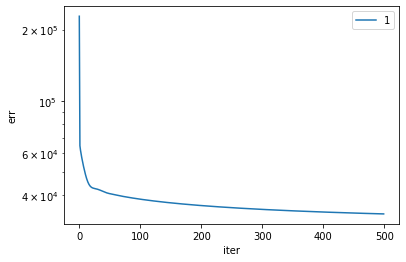

In [19]:
print_loss_dyn(loss_dynamics1, 1)

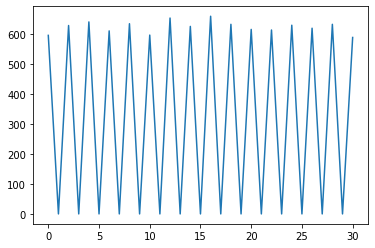

In [20]:
dimdim = tf.constant([2,2,2,2,2], dtype=tf.int32)
counts = util.tf_ravel_multi_index(QC.samples_vault['5H'], dimdim)
hist1 = tf.math.bincount(counts)
plt.plot(hist1)

In [21]:
difff = (get_complex_channel_form(QC.workspace_set)['H'] - QC.hidden_set['H']).numpy()

In [22]:
tf.linalg.norm(QC.hidden_set['H'] - get_complex_channel_form(QC.workspace_set)['H'], axis = (-2, -1))

<tf.Tensor: shape=(5,), dtype=complex64, numpy=
array([0.14394122+0.j, 0.49816415+0.j, 0.1567188 +0.j, 0.02044359+0.j,
       2.828424  +0.j], dtype=complex64)>

In [23]:
tf.linalg.norm(QC.hidden_set['H'] - QC.ideal_set[0], axis = (-2, -1))

<tf.Tensor: shape=(5,), dtype=complex64, numpy=
array([0.      +0.j, 0.      +0.j, 0.      +0.j, 0.      +0.j,
       2.828427+0.j], dtype=complex64)>

In [24]:
tf.linalg.norm(QC.ideal_set[0] - get_complex_channel_form(QC.workspace_set)['H'], axis = (-2, -1))

<tf.Tensor: shape=(5,), dtype=complex64, numpy=
array([0.14394122+0.j, 0.49816415+0.j, 0.1567188 +0.j, 0.02044359+0.j,
       1.979902  +0.j], dtype=complex64)>

In [25]:
get_complex_channel_form(QC.workspace_set)

{'H': <tf.Tensor: shape=(5, 4, 4), dtype=complex64, numpy=
 array([[[ 5.5082494e-01+0.j,  4.9741000e-01+0.j,  4.9741000e-01+0.j,
           4.4917497e-01+0.j],
         [ 4.9741012e-01+0.j, -5.5082488e-01+0.j,  4.4917494e-01+0.j,
          -4.9741000e-01+0.j],
         [ 4.9741012e-01+0.j,  4.4917494e-01+0.j, -5.5082488e-01+0.j,
          -4.9741000e-01+0.j],
         [ 4.4917506e-01+0.j, -4.9741009e-01+0.j, -4.9741009e-01+0.j,
           5.5082488e-01+0.j]],
 
        [[ 6.2040210e-01+0.j,  4.3121958e-01+0.j,  4.3121958e-01+0.j,
           3.0009392e-01+0.j],
         [ 4.5486560e-01+0.j, -6.4252323e-01+0.j,  3.1203979e-01+0.j,
          -4.5015904e-01+0.j],
         [ 4.5486560e-01+0.j,  3.1203979e-01+0.j, -6.4252323e-01+0.j,
          -4.5015904e-01+0.j],
         [ 3.7959805e-01+0.j, -4.3121952e-01+0.j, -4.3121952e-01+0.j,
           6.9990605e-01+0.j]],
 
        [[ 4.5532063e-01+0.j,  4.5089149e-01+0.j,  4.5089149e-01+0.j,
           4.4695768e-01+0.j],
         [ 4.8153284e-01+0

In [26]:
QC.ideal_set[0]

<tf.Tensor: shape=(4, 4), dtype=complex64, numpy=
array([[ 0.50000006+0.j,  0.50000006+0.j,  0.50000006+0.j,
         0.50000006+0.j],
       [ 0.50000006+0.j, -0.50000006+0.j,  0.50000006+0.j,
        -0.50000006+0.j],
       [ 0.50000006+0.j,  0.50000006+0.j, -0.50000006+0.j,
        -0.50000006+0.j],
       [ 0.50000006+0.j, -0.50000006+0.j, -0.50000006+0.j,
         0.50000006+0.j]], dtype=complex64)>